In [1]:
%load_ext lab_black

# Inference for the discount factor

This example illustrates parameter inference for the discount factor $\delta$ for the setting of Keane-Wolpin [(1994)](https://www.jstor.org/stable/2109768?seq=1).

In this example the following moduels from `respyabc` are used:

- Distance function for the descriptives:`distances.compute_mean_squared_distance`
- Get point estimate from inference: `evaluation.compute_point_estimate`
- Plot credibility intervals from inference:`evaluation.plot_credible_intervals`
- Plot posterior distribution from inference:`evaluation.plot_kernel_density_posterior`
- Simulation function of the model:`models.compute_model` 
- Inference function:`respyabc.respyabc`

We can import the necessary classes and packages by

In [2]:
import respy as rp
import numpy as np

import time

from respyabc.distances import compute_mean_squared_distance
from respyabc.evaluation import compute_point_estimate
from respyabc.evaluation import plot_credible_intervals
from respyabc.evaluation import plot_kernel_density_posterior
from respyabc.models import compute_model
from respyabc.respyabc import respyabc
from respyabc.tools import convert_time

## Load the default settings

First, we load the settings from the first model in Keane-Wolpin [(1994)](https://www.jstor.org/stable/2109768?seq=1) using `respy`. 

In [3]:
params, options, data_stored = rp.get_example_model("kw_94_one")

The model consits of 4 choices *sector a, sector b, schooling* and *staying at home*. This yields 30 parameters within the model. In this tutorial, we only vary over the discount factor, which is in the standard parameterization $\delta = 0.95$.

In [4]:
params.loc[("delta", "delta")]

value                 0.95
comment    discount factor
Name: (delta, delta), dtype: object

In the standard moel 1000 individuals are simulated and each individual is forward looking over 40 periods.

In [5]:
periods = options["n_periods"]
agents = options["simulation_agents"]
print(
    f"The default setting consits of {periods} periods and of {agents} independent agents."
)

The default setting consits of 40 periods and of 1000 independent agents.


## Simulate the true population

To simulate the true population we need to define the model that is to be simulated, the magnitude of the parameter of interest $\delta$, and the type of descriptive statistics that are used to compute the distance inbetween 2 populations. Naming the parameter `delta_delta` seems to be unnecassarily cumbersome in the first place. However, note that `params` is a multi-indexed data frame.`respyabc` melts both indices to an index and divides them by an underscore, such that the parameter key and the data frame index can be called by one statement.

In [6]:
model_to_simulate = rp.get_simulate_func(params, options)
parameter_true = {"delta_delta": 0.95}

Since in `respy` the seed is modeled within the `options`, we had to circumvent this issue by specifying a random seed inside the function for any random model draw. To ensure reproducible results, we therefore have to set a seed outside of the function that ensures that any seed that is set inside of the function is the same if the mode is run again. 

In [7]:
np.random.seed(123)
pseudo_observed_data = compute_model(
    parameter_true,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="choice_frequencies",
)

## Set the pyABC parameters

We set the size of the `pyABC` samples to 500 and the maximum number of drawn populations to 10. The excact magnitudes in applications depend on the respective application.

In [8]:
population_size = 500
max_nr_populations = 10

The minimum epsilon is set to be 0.05. This was found to be a valid epsilon in previous simulations. In practice, finding a suitbale epsilon is harder and can be done by simulation studies. The prior distribution of $\delta$ is set to the uniform distribution. Choosing a uniform prior has the advantage that the user implicitly sets bounds on the posterior distribution and every value has the same prior density. 

In [9]:
minimum_epsilon = 0.05
delta_prior_low = 0.9
delta_prior_length = 0.09
parameters_prior = {"delta_delta": [[delta_prior_low, delta_prior_length], "uniform"]}

The dictionry must be read as follow. `"delta_delta"` is the key identifier, `delta_prior_low` is the lower bound of the uniform distribution and `delta_prioir_length` is the length of the uniform interval and **not** the upper bound. This is to be in line with the logic of `pyABC`, which follows `scipy`.  

## respyabc inference

As distance, we used the mean squared distances of the choice frequencies of any period. After specifying all relevant parameters, inference is conducted by using the `respyabc` function. We keep track of the simulation time to give the user a first glimpse about the timing. 

In [10]:
np.random.seed(1234)
start_delta = time.perf_counter()
history = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior,
    data=pseudo_observed_data,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
)
end_delta = time.perf_counter()

/home/manuel/anaconda3/lib/python3.7/site-packages/respy/pre_processing/model_processing.py:104: UserWarning: All seeds should be different.
  warnings.warn("All seeds should be different.", category=UserWarning)


In [11]:
delta_time, delta_unit = convert_time(end_delta - start_delta)
f"The respyabc run for delta using choice frequencies took {delta_time:0.2f} {delta_unit}"

'The respyabc run for delta using choice frequencies took 21.87 minutes'

## respyabc evaluation

Since `respyabc` returns the same type of history as the [`pyabc.ABCSMC`](https://pyabc.readthedocs.io/en/latest/api_inference.html) function, all model assessment that can be done with this class is feasible for `respyabc` model run. Additionally, we offer evaluation of the respective runs by easy implementation of plots for credibility intervals and posterior distributions.  

First, we compute the point estimate and its variance. The estimate is computed by `point_estimate` as a weighted average over the latest simulated population. 

In [12]:
estimate = compute_point_estimate(history)
estimate

name,delta_delta
estimate,9.505728e-01
est_variance,1.425137e-09


To obtain a broader overview on how the estimates evolve over the runs, we have implemented $95\%$ credibility intervals by the function `plot_credible_intervals`. The argument `interval_type=simulated` indicates that the credibility intervals are computed as $2.5\%$ and $97.5\%$ percentiles of the simulated population.

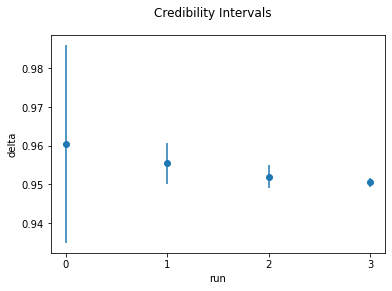

In [13]:
plot_credible_intervals(
    history=history,
    parameter="delta_delta",
    interval_type="simulated",
    alpha=0.05,
    main_title="Credibility Intervals",
    y_label="delta",
)

To conclude, we can estimate the full posterior distribution as a kernel density estimate using the respective populations and weights.

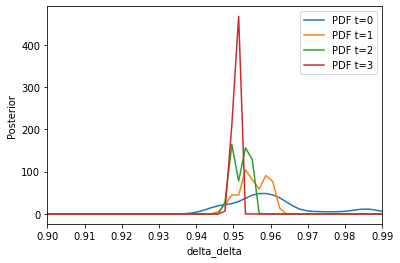

In [14]:
xmax = delta_prior_low + delta_prior_length
plot_kernel_density_posterior(
    history=history, parameter="delta_delta", xmin=delta_prior_low, xmax=xmax
)